In [1]:
import numpy as np
import pandas as pd 
import mne 

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import scipy.io as sio

from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

%matplotlib notebook

In [2]:
patient_dir = "ExampleSig/"

vhdr_file = patient_dir + "AntoineMaioSuite.vhdr"
physiological_file = patient_dir + "PhysiologicalSig.txt"

### Eye-tracking and Head Position Loading 

In [3]:
col = ["time","x","y","z","rot x","rot y","rot z", "x eye", "y eye", "z eye","x dir eye","y dir eye","z dir eye", "pupil","blink lef","blink right"]      
data = np.loadtxt(physiological_file)
df = pd.DataFrame(data=data,columns=col )
df

,time,x,y,z,rot x,rot y,rot z,x eye,y eye,z eye,x dir eye,y dir eye,z dir eye,pupil,blink lef,blink right
0,0.200,-1.99141,2.26483,-0.05904,358.04175,2.46575,355.48395,-1.992,2.266,-0.055,0.027,-0.043,0.999,2.733,0.000,0.000
1,0.400,-1.99143,2.26459,-0.05850,358.13217,2.49773,355.46933,-1.993,2.266,-0.054,0.022,-0.050,0.998,2.537,0.000,0.000
2,0.600,-1.99164,2.26424,-0.05774,358.26089,2.41046,355.49561,-1.989,2.265,-0.054,-0.131,-0.022,0.991,2.372,0.000,0.000
3,0.800,-1.99130,2.26430,-0.05753,358.25314,2.32403,355.44870,-1.988,2.265,-0.053,-0.122,-0.020,0.992,2.349,0.000,0.000
4,1.000,-1.99111,2.26425,-0.05807,358.19519,2.30513,355.40735,-1.990,2.265,-0.053,-0.123,-0.024,0.992,2.390,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4129,826.184,-1.99920,2.30592,-0.11246,0.47410,344.64474,5.63204,-2.034,2.306,-0.115,-0.150,-0.113,0.982,3.432,825.783,825.823
4130,826.384,-1.99122,2.30627,-0.12783,357.94189,345.83710,5.49406,-2.024,2.305,-0.124,-0.296,-0.088,0.951,3.130,826.344,826.364
4131,826.584,-1.98726,2.30698,-0.14229,355.17578,345.17340,5.46196,-1.981,2.310,-0.132,-0.305,-0.038,0.952,3.480,826.344,826.364
4132,826.784,-1.98979,2.30551,-0.14307,354.75980,344.26910,5.53563,-1.981,2.310,-0.132,-0.305,-0.038,0.952,3.480,826.344,826.364


### Raw EEG Loading 

In [4]:
raw_sig = mne.io.read_raw_brainvision(vhdr_file)

Extracting parameters from Maio/AntoineMaioSuite.vhdr...
Setting channel info structure...


<ipython-input-4-fee16300b13f>:1: DeprecationWarning: The `montage` parameter from `read_raw_brainvision` is deprecated and will be removed  in version 0.20. Use  raw.set_montage(montage) instead.
  raw_sig = mne.io.read_raw_brainvision(vhdr_file)


Plot the signal with mne, but run this in a new window (fit better).

<IPython.core.display.Javascript object>


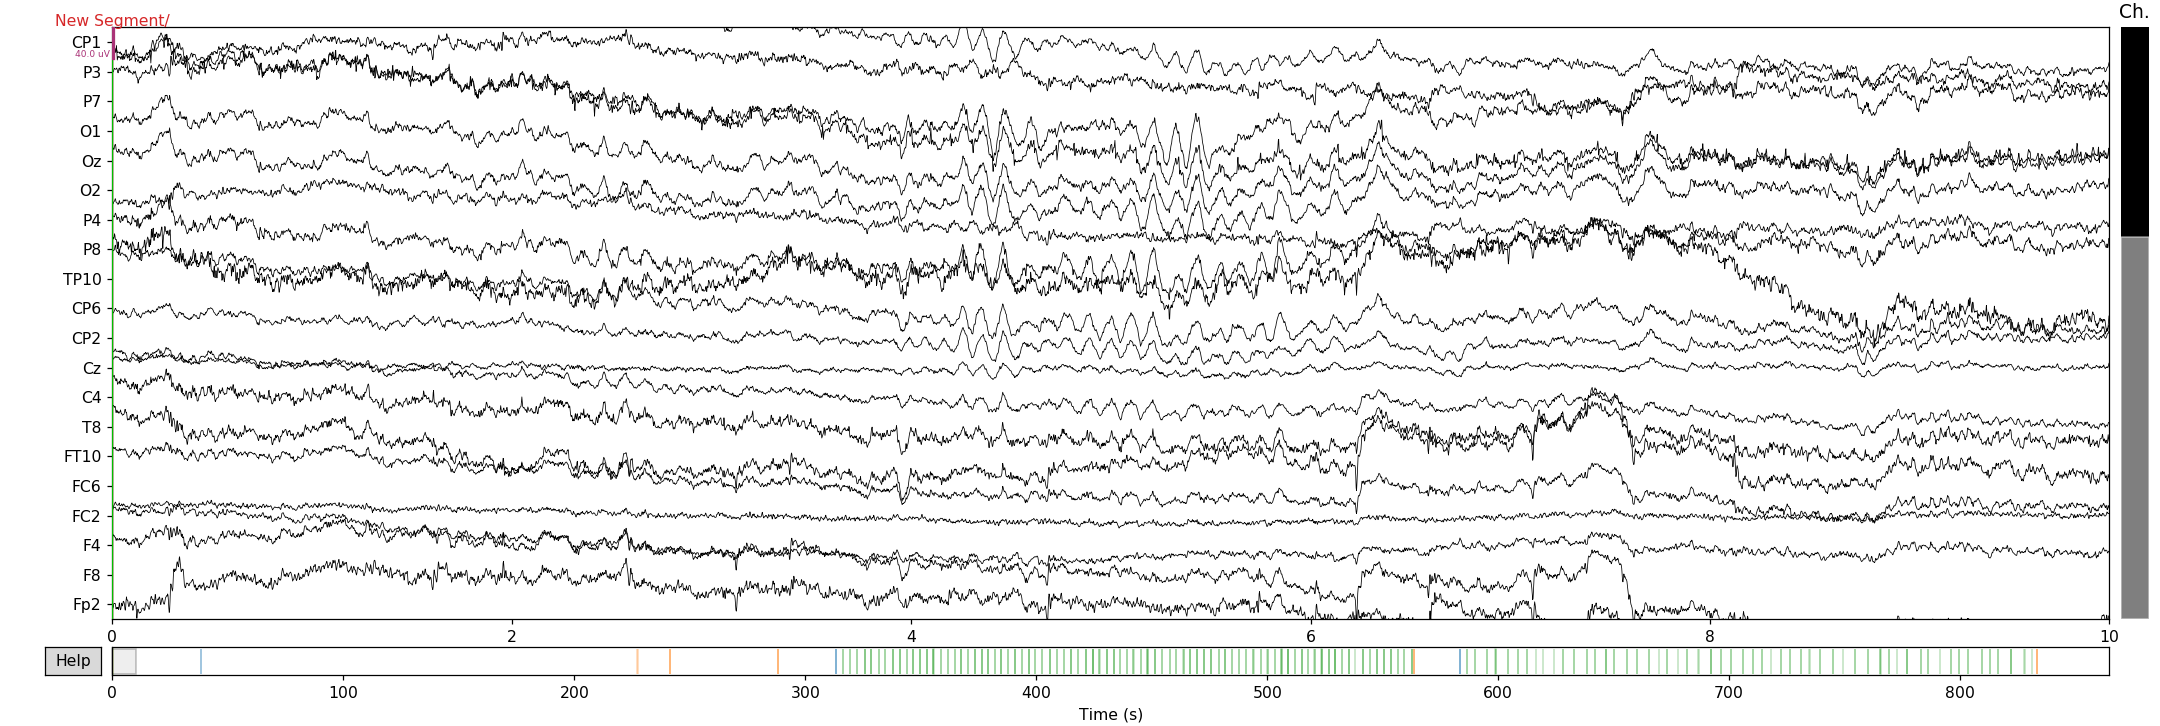

In [5]:
raw_sig.plot()
plt.show()

#### Spectral Analysis

In [ ]:
win_len = 3 
overlap_time = 0.2 
time = np.asarray(df.time)

fmin, fmax = 2, 50

PSD = []
j = 0

for i in tqdm(range(int((df.time.max()-win_len)/0.2))):
    id_time = np.logical_and((time > i*overlap_time),(time < (i+1)*(win_len+overlap_time) ))
    tmin = time[id_time][0]
    tmax = time[id_time][-1]
    
    psds, freqs = mne.time_frequency.psd_multitaper(raw_sig, low_bias=True, tmin=tmin, tmax=tmax,
                             fmin=fmin, fmax=fmax, proj=True, n_jobs=6, verbose='error')
    PSD.append([psds.mean(0), freqs])
    
sio.savemat("PSD.mat", {"psd":PSD})

In [6]:
sig_psd = sio.loadmat(patient_dir+"PSD.mat")["psd"]

In [7]:
theta_lim = [4,8]
alpha_lim = [8,15]
beta_lim = [15,25]

theta_amp = np.zeros(sig_psd.shape[0])
alpha_amp = np.zeros(sig_psd.shape[0])
beta_amp = np.zeros(sig_psd.shape[0])

for i in tqdm(range(sig_psd.shape[0])):
    id_theta = np.logical_and(sig_psd[i,1][0] > theta_lim[0], sig_psd[i,1][0] < theta_lim[1])
    id_alpha = np.logical_and(sig_psd[i,1][0] > alpha_lim[0], sig_psd[i,1][0] < alpha_lim[1])
    id_beta = np.logical_and(sig_psd[i,1][0] > beta_lim[0], sig_psd[i,1][0] < beta_lim[1])

    theta_amp[i] = np.mean(sig_psd[i,0][0][id_theta])
    alpha_amp[i] = np.mean(sig_psd[i,0][0][id_alpha])
    beta_amp[i] = np.mean(sig_psd[i,0][0][id_beta])

100%|████████████████████████████████████████████████████████████████████████████| 4118/4118 [00:00<00:00, 9831.02it/s]


In [8]:
scaler = MinMaxScaler()
beta_amp = scaler.fit_transform(beta_amp.reshape(-1,1))
alpha_amp = scaler.fit_transform(alpha_amp.reshape(-1,1))
theta_amp = scaler.fit_transform(theta_amp.reshape(-1,1))

<IPython.core.display.Javascript object>


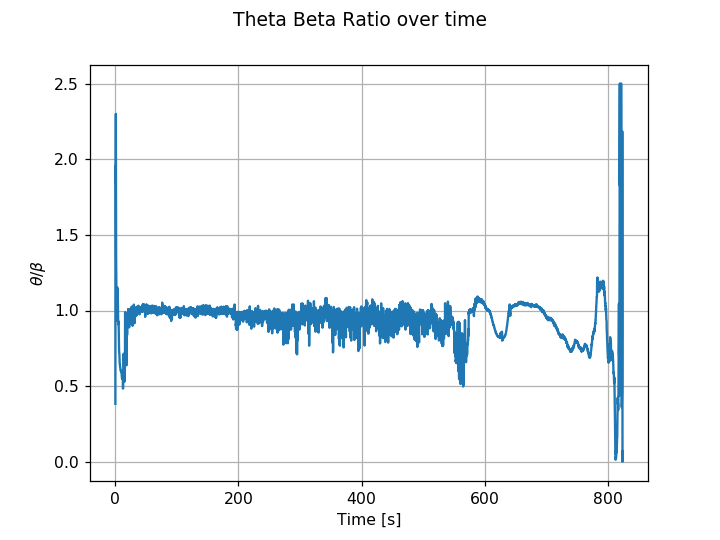

<ipython-input-9-7b1a613f6b07>:2: RuntimeWarning: divide by zero encountered in true_divide
  tbr = theta_amp/beta_amp


In [9]:
fig = plt.figure()
tbr = theta_amp/beta_amp
tbr[tbr>2.5] = 2.5
plt.grid()

time = np.asarray(df.time)[0:len(tbr)]
plt.xlabel("Time [s]")
plt.ylabel("$\\theta/ \\beta $")

plt.suptitle("Theta Beta Ratio over time")
plt.plot(time,tbr)

### Display Task result
Task 2 

<IPython.core.display.Javascript object>


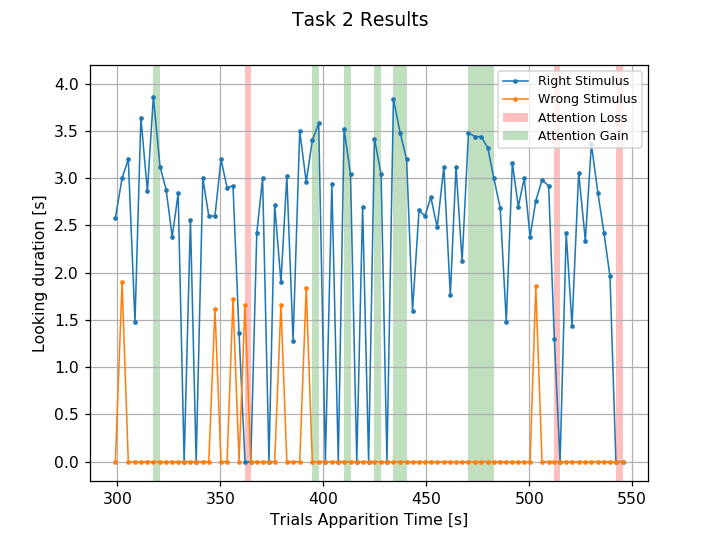

In [10]:
task2 = np.loadtxt(patient_dir+"TotalTask2.txt")
right_time = task2[::2]
wrong_time = -task2[1::2]
app_time = np.loadtxt(patient_dir+"Task2Stim.txt")[:,0]

absolute_res = right_time - wrong_time
scaler = MinMaxScaler()
scaler.fit(absolute_res[right_time>wrong_time].reshape(-1,1))
absolute_res = scaler.transform(absolute_res.reshape(-1,1))
del scaler

fig = plt.figure()
plt.plot(app_time, right_time,'-o',markersize=2,linewidth=1, label = 'Right Stimulus')
plt.plot(app_time,wrong_time,'-o',markersize=2,linewidth=1, label = 'Wrong Stimulus')
ax = plt.gca()
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
plt.fill_between(app_time, 0, 4, where=(absolute_res<0.3).squeeze() ,
                facecolor='red', alpha=0.25, transform=trans, label ="Attention Loss")
plt.fill_between(app_time, 0, 4, where=(absolute_res>0.75).squeeze() ,
                facecolor='green', alpha=0.25, transform=trans, label = "Attention Gain")
plt.legend(fontsize=8)
plt.xlabel("Trials Apparition Time [s]")
plt.ylabel("Looking duration [s]")
plt.suptitle("Task 2 Results")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


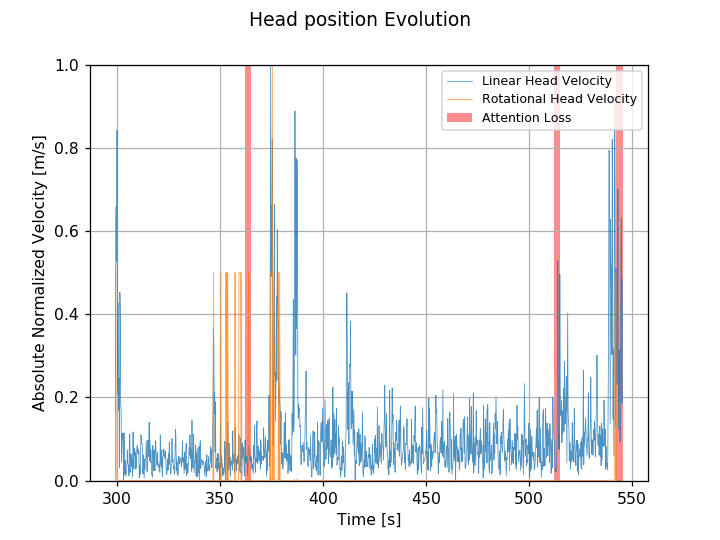

In [11]:
fig = plt.figure()

scaler = MinMaxScaler()

time = np.asarray(df.time)

id_task2 = np.logical_and((time > app_time[0]), (time < app_time[-1]))

diff_x = np.diff(np.asarray(df.x))
diff_y = np.diff(np.asarray(df.y))
diff_z = np.diff(np.asarray(df.z))

time = time[id_task2]
diff_x = diff_x[id_task2[0:-1]]
diff_y = diff_y[id_task2[0:-1]]
diff_z = diff_z[id_task2[0:-1]]

linear_head = scaler.fit_transform((np.abs(diff_x)+np.abs(diff_y)+np.abs(diff_z)).reshape(-1,1))

diff_x = np.diff(np.asarray(df["rot x"]))
diff_y = np.diff(np.asarray(df["rot y"]))
diff_z = np.diff(np.asarray(df["rot z"]))

diff_x = diff_x[id_task2[0:-1]]
diff_y = diff_y[id_task2[0:-1]]
diff_z = diff_z[id_task2[0:-1]]

rot_head = scaler.fit_transform((np.abs(diff_x)+np.abs(diff_y)+np.abs(diff_z)).reshape(-1,1))

plt.plot(time,linear_head,linewidth=0.5, alpha = 0.8, label ="Linear Head Velocity")
plt.plot(time,rot_head,linewidth=0.5, alpha = 0.8, label ="Rotational Head Velocity")
ax = plt.gca()
ax.set_ylim([0,1])

plt.fill_between(app_time, 0, 1, where=(absolute_res<0.3).squeeze() ,
                facecolor='red', alpha=0.45, transform=trans, label ="Attention Loss")

#plt.fill_between(app_time, 0, 1, where=(absolute_res>0.75).squeeze() ,
#                facecolor='green', alpha=0.45, transform=trans, label = "Attention Gain")

plt.legend(fontsize=8)
plt.xlabel("Time [s]")
plt.ylabel("Absolute Normalized Velocity [m/s]")
plt.suptitle("Head position Evolution")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


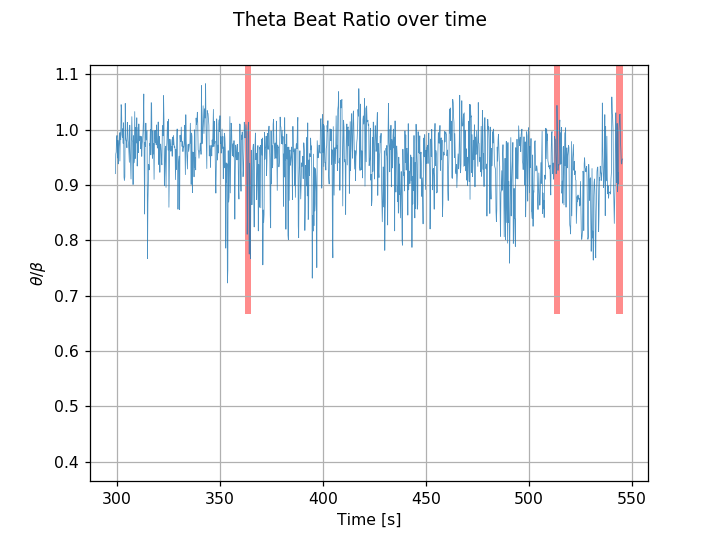

In [12]:
fig = plt.figure()



scaler = MinMaxScaler()

time = np.asarray(df.time)

id_task2 = np.logical_and((time > app_time[0]), (time < app_time[-1]))

time = time[0:len(tbr)][id_task2[0:len(tbr)]]
tbr_task2 = tbr[id_task2[0:len(tbr)]]


plt.plot(time,tbr_task2,linewidth=0.5, alpha = 0.8)
ax = plt.gca()
plt.fill_between(app_time, 0.4, 1, where=(absolute_res<0.3).squeeze() ,
                facecolor='red', alpha=0.45, transform=trans)

#ax.set_ylim([0.75,1.1])
#plt.fill_between(app_time, 0, 1, where=(absolute_res>0.75).squeeze() ,
#                facecolor='green', alpha=0.45, transform=trans, label = "Attention Gain")

#plt.legend(fontsize=8)
plt.xlabel("Time [s]")
plt.ylabel("$\\theta/ \\beta $")
plt.suptitle("Theta Beat Ratio over time")
plt.grid()
plt.show()

Task 3

<IPython.core.display.Javascript object>


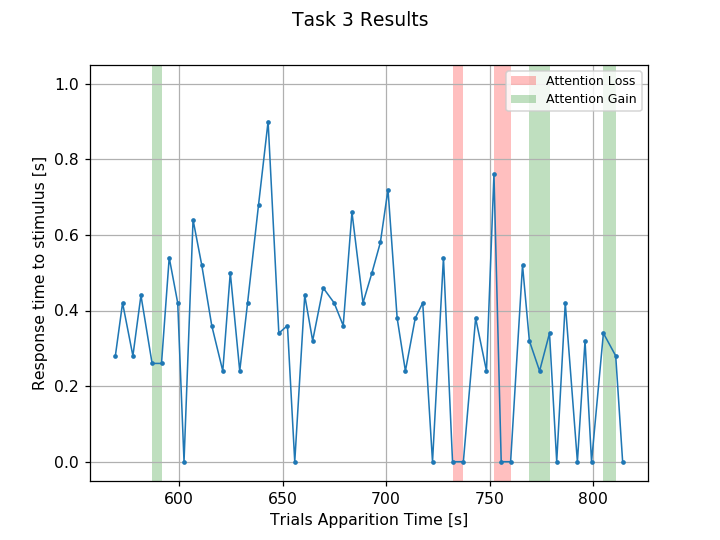

In [13]:
task3 = np.loadtxt(patient_dir+"TotalTask3.txt")
app_time = np.loadtxt(patient_dir+"Task3Stim.txt")[:,0]

scaler = MinMaxScaler()
absolute_res = scaler.fit_transform(np.abs(task3).reshape(-1,1))

task3[task3<0]=0

fig = plt.figure()
plt.plot(app_time, task3,'-o',markersize=2,linewidth=1)
ax = plt.gca()
trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
plt.fill_between(app_time, 0, 1, where=(absolute_res>0.6).squeeze() ,
                facecolor='red', alpha=0.25, transform=trans, label ="Attention Loss")
plt.fill_between(app_time, 0, 1, where=(absolute_res<0.15).squeeze() ,
                facecolor='green', alpha=0.25, transform=trans, label = "Attention Gain")
plt.legend(fontsize=8)
plt.xlabel("Trials Apparition Time [s]")
plt.ylabel("Response time to stimulus [s]")
plt.suptitle("Task 3 Results")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


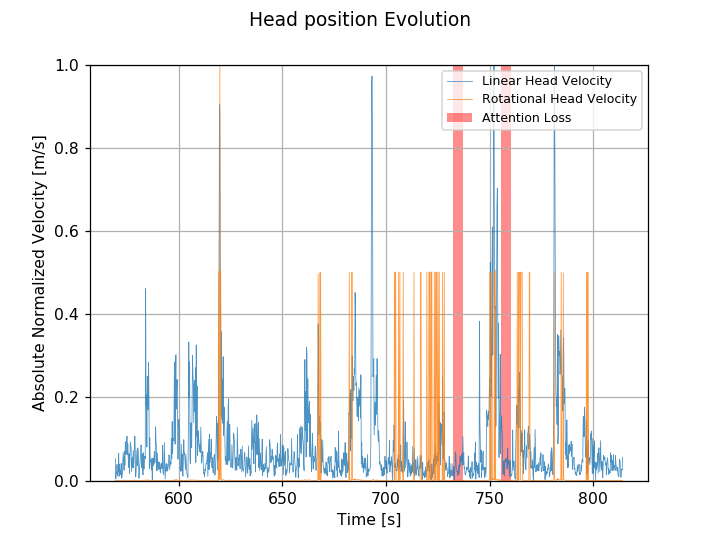

In [14]:
fig = plt.figure()

scaler = MinMaxScaler()

time = np.asarray(df.time)

id_task2 = np.logical_and((time > app_time[0]), (time < app_time[-1]))

diff_x = np.diff(np.asarray(df.x))
diff_y = np.diff(np.asarray(df.y))
diff_z = np.diff(np.asarray(df.z))

time = time[id_task2]
diff_x = diff_x[id_task2[0:-1]]
diff_y = diff_y[id_task2[0:-1]]
diff_z = diff_z[id_task2[0:-1]]

linear_head = scaler.fit_transform((np.abs(diff_x)+np.abs(diff_y)+np.abs(diff_z)).reshape(-1,1))

diff_x = np.diff(np.asarray(df["rot x"]))
diff_y = np.diff(np.asarray(df["rot y"]))
diff_z = np.diff(np.asarray(df["rot z"]))

diff_x = diff_x[id_task2[0:-1]]
diff_y = diff_y[id_task2[0:-1]]
diff_z = diff_z[id_task2[0:-1]]

rot_head = scaler.fit_transform((np.abs(diff_x)+np.abs(diff_y)+np.abs(diff_z)).reshape(-1,1))

plt.plot(time,linear_head,linewidth=0.5, alpha = 0.8, label ="Linear Head Velocity")
plt.plot(time,rot_head,linewidth=0.5, alpha = 0.8, label ="Rotational Head Velocity")
ax = plt.gca()
ax.set_ylim([0,1])

plt.fill_between(app_time, 0, 1, where=(absolute_res>0.8).squeeze() ,
                facecolor='red', alpha=0.45, transform=trans, label ="Attention Loss")

#plt.fill_between(app_time, 0, 1, where=(absolute_res>0.75).squeeze() ,
#                facecolor='green', alpha=0.45, transform=trans, label = "Attention Gain")

plt.legend(fontsize=8)
plt.xlabel("Time [s]")
plt.ylabel("Absolute Normalized Velocity [m/s]")
plt.suptitle("Head position Evolution")
plt.grid()
plt.show()

<IPython.core.display.Javascript object>


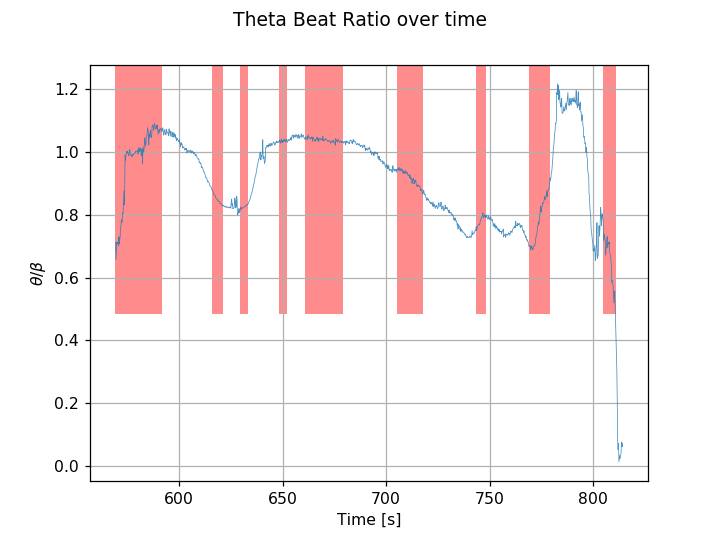

In [15]:
fig = plt.figure()



scaler = MinMaxScaler()

time = np.asarray(df.time)

id_task2 = np.logical_and((time > app_time[0]), (time < app_time[-1]))

time = time[0:len(tbr)][id_task2[0:len(tbr)]]
tbr_task2 = tbr[id_task2[0:len(tbr)]]


plt.plot(time,tbr_task2,linewidth=0.5, alpha = 0.8)
ax = plt.gca()
plt.fill_between(app_time, 0.4, 1, where=(absolute_res<0.3).squeeze() ,
                facecolor='red', alpha=0.45, transform=trans)

#ax.set_ylim([0.75,1.1])
#plt.fill_between(app_time, 0, 1, where=(absolute_res>0.75).squeeze() ,
#                facecolor='green', alpha=0.45, transform=trans, label = "Attention Gain")

#plt.legend(fontsize=8)
plt.xlabel("Time [s]")
plt.ylabel("$\\theta/ \\beta $")
plt.suptitle("Theta Beat Ratio over time")
plt.grid()
plt.show()

## Simple Regressor Implementation

In [16]:
app_time = np.concatenate((np.loadtxt(patient_dir+"Task2Stim.txt")[:,0],np.loadtxt(patient_dir+"Task3Stim.txt")[:,0]))

#task2
absolute_res = right_time - wrong_time
scaler = MinMaxScaler()
scaler.fit(absolute_res[right_time>wrong_time].reshape(-1,1))
absolute_res2 = scaler.transform(absolute_res.reshape(-1,1))
del scaler 

#task3
scaler = MinMaxScaler()
absolute_res3 = scaler.fit_transform(np.abs(task3).reshape(-1,1))
absolute_res3[absolute_res3==0]=1
absolute_res3 = 1-absolute_res3
result = np.concatenate((absolute_res2,absolute_res3))

result[result<0]=0

Label = (result>0.5).astype(int)

### Feature Vector Construction

In [17]:
diff_x = np.diff(np.asarray(df.x))
diff_y = np.diff(np.asarray(df.y))
diff_z = np.diff(np.asarray(df.z))

linear_head = scaler.fit_transform((np.abs(diff_x)+np.abs(diff_y)+np.abs(diff_z)).reshape(-1,1))

diff_x = np.diff(np.asarray(df["rot x"]))
diff_y = np.diff(np.asarray(df["rot y"]))
diff_z = np.diff(np.asarray(df["rot z"]))

rot_head = scaler.fit_transform((np.abs(diff_x)+np.abs(diff_y)+np.abs(diff_z)).reshape(-1,1))

linear_head = linear_head[0:len(alpha_amp)]
rot_head = rot_head[0:len(alpha_amp)]
time = np.asarray(df.time)[0:len(alpha_amp)]

In [18]:
window_len = 2.5
overlap_time = 0.2

Feat_vec = np.zeros((len(app_time), 6*int(window_len/overlap_time)))

for i in range(len(app_time)):
    id_time = np.logical_and(time > app_time[i] - window_len +0.2*overlap_time , time < app_time[i])
    Feat_vec[i,0:int(window_len/overlap_time)] = linear_head[id_time][0:int(window_len/overlap_time)] .squeeze()
    Feat_vec[i,int(window_len/overlap_time):2*int(window_len/overlap_time)] = rot_head[id_time][0:int(window_len/overlap_time)].squeeze()
    Feat_vec[i,2*int(window_len/overlap_time):3*int(window_len/overlap_time)] = alpha_amp[id_time][0:int(window_len/overlap_time)].squeeze()
    Feat_vec[i,3*int(window_len/overlap_time):4*int(window_len/overlap_time)] = beta_amp[id_time][0:int(window_len/overlap_time)].squeeze()
    Feat_vec[i,4*int(window_len/overlap_time):5*int(window_len/overlap_time)] = theta_amp[id_time][0:int(window_len/overlap_time)].squeeze()
    Feat_vec[i,5*int(window_len/overlap_time):6*int(window_len/overlap_time)] = tbr[id_time][0:int(window_len/overlap_time)].squeeze()

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(Feat_vec, Label, test_size=0.25, random_state=42)

### Classifier Models
#### Linear Classifier

In [21]:
from sklearn.linear_model import SGDClassifier

Lin_Classifier = SGDClassifier()

Lin_Classifier.fit(X_train, y_train)
Lin_Classifier.score(X_test, y_test)

c:\users\victo\.conda\envs\pyp300\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6285714285714286

#### Support Vector Machine

In [22]:
from sklearn.svm import SVC as svc
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from scipy import stats

svm_classifier = svc()
auc = make_scorer(roc_auc_score)

grid_list = {"kernel" : ['linear', 'poly', 'rbf', 'sigmoid']}
grid_search = GridSearchCV(svm_classifier, param_grid=grid_list, n_jobs=-1, cv=5, scoring=auc)
grid_search.fit(Feat_vec,Label)
param_grid = grid_search.best_params_

svm_classifier = svc(grid_search.best_params_)
rand_list = {"C": stats.uniform(2, 10),
             "gamma":stats.uniform(0.1, 1)}
rand_search = RandomizedSearchCV(svm_classifier, param_distributions = rand_list,  n_jobs = -1, cv = 5, random_state = 42, scoring = auc) 
rand_search.fit(Feat_vec, Label) 
param_rand = rand_search.best_params_

c:\users\victo\.conda\envs\pyp300\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\victo\.conda\envs\pyp300\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
svm_classifier = svc(kernel='linear', C=5.74540118, gamma=1.050714)
svm_classifier.fit(X_train,y_train)
svm_classifier.score(X_test, y_test)

c:\users\victo\.conda\envs\pyp300\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6857142857142857

#### Gaussian Naive Bayes

In [24]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
auc = make_scorer(roc_auc_score)

gnb.fit(X_train,y_train)
gnb.score(X_test, y_test)

c:\users\victo\.conda\envs\pyp300\lib\site-packages\sklearn\naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.6571428571428571

### Results Analysis

In [25]:
tot_score = []
n_time = 100000
Lin_Classifier.verbose = False
svm_classifier.verbose = False
gnb.verbose = False

import warnings
warnings.filterwarnings('ignore')

for i in tqdm(range(n_time)):
    X_train, X_test, y_train, y_test = train_test_split(Feat_vec, Label, test_size=0.25)
    Lin_Classifier.fit(X_train, y_train)
    svm_classifier.fit(X_train,y_train)
    gnb.fit(X_train,y_train)
    
    tot_score.append([Lin_Classifier.score(X_test,y_test), svm_classifier.score(X_test,y_test), gnb.score(X_test,y_test)])
tot_score = np.asarray(tot_score)

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [05:03<00:00, 329.40it/s]


<IPython.core.display.Javascript object>


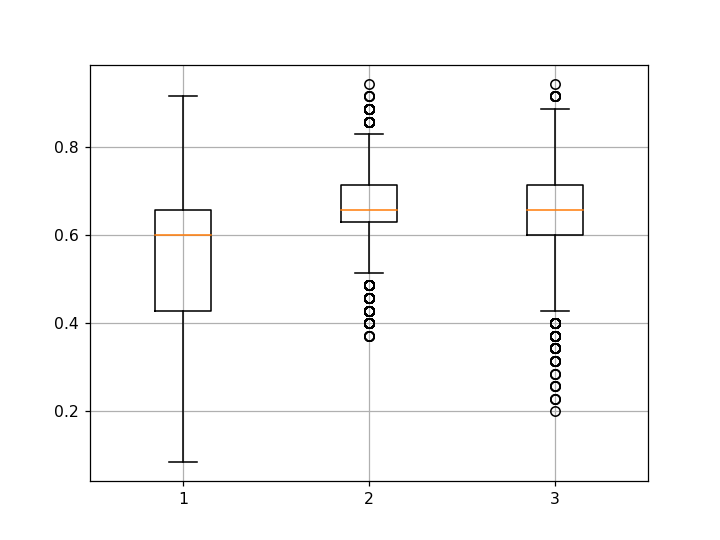

In [26]:
fig = plt.figure()
plt.boxplot(tot_score)

plt.grid()
plt.suptitle("")

plt.show()